<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".


Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.


В обучающей выборке *train_sessions.csv*:

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем *site_dic.pkl*)
Признаки time_j – время посещения сайтов site_j
Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)
Задача – сделать прогнозы для сессий в тестовой выборке (*test_sessions.csv*), определить, принадлежат ли они Элис. Не обязательно ограничиваться только предложенной выборкой *train_sessions.csv* – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

In [2]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
import pickle
from collections import Counter
import math
import operator
from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import hstack


Reading original data

In [3]:
PATH_TO_DATA = ('../../data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

AttributeError: 'weekday' object has no attribute 'holidays'

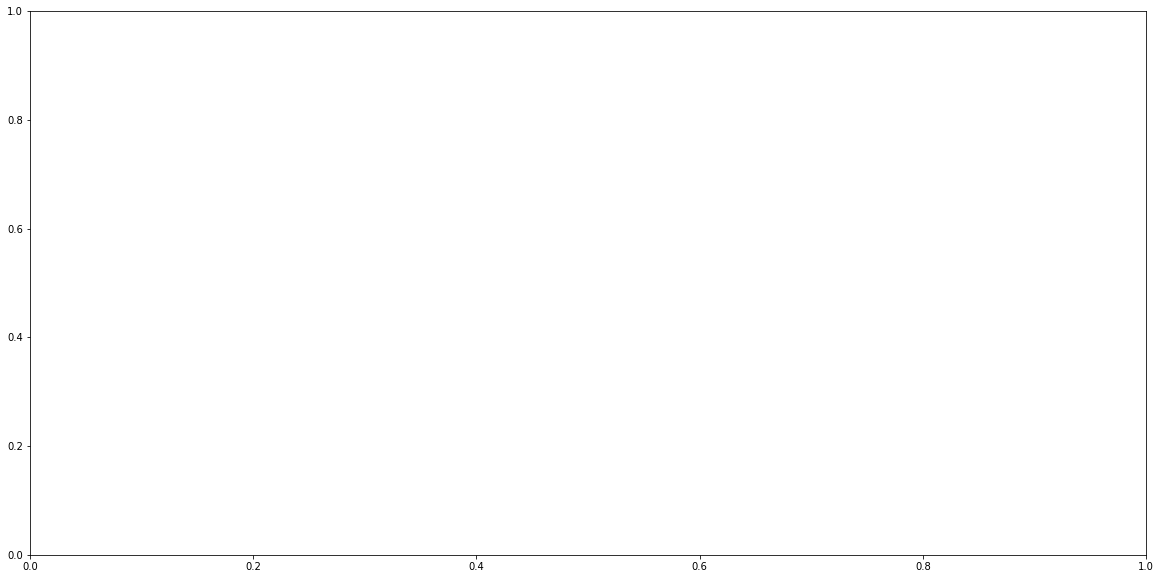

In [21]:
import time
import datetime as dt
fig, ax = plt.subplots(figsize=(20,10)) 

start = dt.datetime.strptime('2014-03-17 00:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2014-03-19 01:00:00', '%Y-%m-%d %H:%M:%S')

#train_for_check = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='time1', parse_dates=['time1'])
#train_for_check = train_for_check[train_for_check['target'] == 1]
#y_may = train_for_check[str(start):str(end)]['target']

#print(train_df[train_df['target'] == 1].shape)
times = ['time%s' % i for i in range(1, 11)]

#y_may.plot(style='k.', ax=ax)
train_df[times] = train_df[times].apply(pd.to_datetime)

train_df['start_session_day'] = train_df['time1'].dt.day

train_df['start_session_day_of_the_week'] = train_df['time1'].dt.dayofweek
train_df["start_session_hour"] = train_df['time1'].dt.hour
train_df['start_session_month'] = train_df['time1'].dt.month

# platform_genre_sales = train_df.pivot_table(
#                         index='start_session_day_of_the_week', 
#                         columns='start_session_day', 
#                         values='target', 
#                         aggfunc=sum).fillna(0).applymap(float)
# sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5)

import pandas.tseries.holiday as hol
us_cal = hol.
dr = pd.date_range(start='2013-07-01', end='2015-08-01')
us_holidays = us_cal.holidays(start=dr.min(), end=dr.max())
train_df['Holiday'] = train_df['time1'].isin(us_holidays)

print(train_df['Holiday'].describe())

# pivot = train_df.pivot_table(
#                         index='start_session_day', 
#                         columns='Holiday', 
#                         values='target', 
#                         aggfunc=sum).fillna(0).applymap(float)


# pivot.plot(kind='bar', ax=ax)

platform_genre_sales = train_df.pivot_table(
                        index='Holiday', 
                        columns='start_session_day', 
                        values='target', 
                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5)

#plt.plot(y_may[:210])
#X_may = train_for_check[str(may_start_time):str(may_end_time)]
#times = ['time%s' % i for i in range(2, 11)]
#train_for_check[times] = train_for_check[times].apply(pd.to_datetime)

#train_for_check["pickup_datetime_cutted_to_hour"] = train_for_check['time1'].values.astype('<M8[h]')
#train_for_check["pickup_datetime_cutted_to_hour"] = train_for_check['time1'].dt.hour

#train_for_check.plot(x='pickup_datetime_cutted_to_hour', y='target')

In [10]:
train_for_check['target'].plot(ax=ax)
plt.show()

Separate target feature 

In [494]:
y = train_df['target']

In [495]:
# Read the training and test data sets
# train_df = pd.read_csv('../input/train_sessions.csv',
#                        index_col='session_id')
# test_df = pd.read_csv('../input/test_sessions.csv',
#                       index_col='session_id')

# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [496]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
42218,www.afdas.com
9415,testng.org
6911,www.iforex.com
24008,lamuruanimacion.wordpress.com
2525,www.qdabra.com


In [497]:
train_df['text'] = train_df[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)


In [498]:
# full_sites = full_df[sites]
# full_sites.head()# sequence of indices
# sites_flatten = full_sites.values.flatten()

# # and the matrix we are looking for
# full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
#                                 sites_flatten,
#                                 range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]


In [499]:
#tiana [17 hours ago]
#мне помогло сделать графики когда алиса в интернет ходит (дни, часы и т.д.),  даже не пришлось tf-idf использовать

In [500]:
train_df[train_df['target']==1].time1.dt.dayofweek.describe()


count    2297.000000
mean        1.584676
std         1.599186
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max         6.000000
Name: time1, dtype: float64

In [501]:
#https://github.com/sudarikova/NLP_tf-idf/blob/master/tfidf.ipynb

In [502]:
train_df['text'] = train_df['text'].apply(lambda x: x.replace('0', ''))

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [503]:
%%time
#a = compute_tfidf(corpus)
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=100000)
X = vectorizer.fit_transform((train_df['text'].apply(lambda x: x.strip().split(' ')).astype(str)).values)
idf = vectorizer.idf_
#print( dict(zip(vectorizer.get_feature_names(), idf)))
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>
CPU times: user 9.9 s, sys: 28 ms, total: 9.93 s
Wall time: 9.94 s


In [504]:
# new_features = ['start_session_hour', 'start_session_day_night', 'start_session_morning', 
#                 'start_session_day_of_the_week',  'alis_top',
#                'start_session_15','start_session_16','start_session_18', 
#                 'start_session_year_14','start_session_year_13', 'is_weekend']
new_features = ['start_session_hour',  
                'start_session_day_of_the_week',  'alis_top',
               'start_session_15','start_session_16','start_session_18', 
                'start_session_year_14','start_session_year_13', 'is_weekend']


# new_features= ['start_session_hour',  
#                 'start_session_day_of_the_week', 'start_session_month', 'alis_top']

train_df["start_session_year_13"] = train_df['time1'].dt.year == 13
train_df["start_session_year_14"] = train_df['time1'].dt.year == 14

train_df["start_session_hour"] = train_df['time1'].dt.hour
train_df["start_session_day_night"] = ((train_df['time1'].dt.hour > 20) | (train_df['time1'].dt.hour < 7)).astype(int)
train_df["start_session_morning"] = ((train_df['time1'].dt.hour > 5) | (train_df['time1'].dt.hour < 12)).astype(int)

train_df['start_session_month'] = train_df['time1'].dt.month
train_df['start_session_day_of_the_week'] = train_df['time1'].dt.dayofweek
train_df['start_session_15'] = (train_df['time1'].dt.hour == 15).astype(int) 
train_df['start_session_16'] = (train_df['time1'].dt.hour == 16).astype(int)
train_df['start_session_18'] = (train_df['time1'].dt.hour == 18).astype(int)
train_df["is_weekend"] = train_df['time1'].dt.weekday.isin([5,6])*1 #индикатор выходных







In [505]:
words = train_df[(train_df['target'] == 1)][sites]

words['text'] = words[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)

all_words_list = [word for word in words['text'].apply(lambda x: x.split(' '))]
import numpy as np
flatten = list(np.array(all_words_list).flat)

In [506]:
#train_df[train_df['start_session_morning'] == 1].head()

In [507]:
from collections import Counter
alis_most_freq_sites = Counter(flatten)#.most_common(100)

#print(alis_most_freq_sites.most_common(10))
alis_top_sites  = sorted(alis_most_freq_sites, key=alis_most_freq_sites.get, reverse=True)[:100]

#print(alis_top_sites)
train_df['alis_top'] = (train_df[sites].astype(str).isin(alis_top_sites)==True).sum(axis=1)



Add features based on the session start time: hour, whether it's morning, day or night and so on.

# You code here
-кол-во сайтов в сессии из ТОП-10 принадлежащих Элис
-месяц начала сессии
-год начала сессии
-час н.с.
-день недели н.с.
-длительность сессии
-средняя длительность сессии

- час
- месяц
- день недели

- утро (0/1)
- ночь (0/1)
- ГГГГММ


сайт == слово 
row - предложение типо

т.е индексы сайтов нужно склеить через пробел в одну строку для каждой сессии, и к этому уже tfidf применять?


Я попробовал обратно замапить id-шники сайтов в URL, потом разбить на компоненты и сделать TF-IDF от получившихся слов. Но что-то это не помогло, хотя считало долго 

In [511]:
train_data = pd.get_dummies(train_df[new_features], columns=['start_session_hour', 
                                        'start_session_day_of_the_week'])

train_data.head()

,start_session_day_night,start_session_morning,alis_top,start_session_15,start_session_16,start_session_18,start_session_year_14,start_session_year_13,is_weekend,start_session_hour_7,...,start_session_hour_21,start_session_hour_22,start_session_hour_23,start_session_day_of_the_week_0,start_session_day_of_the_week_1,start_session_day_of_the_week_2,start_session_day_of_the_week_3,start_session_day_of_the_week_4,start_session_day_of_the_week_5,start_session_day_of_the_week_6
session_id,,,,,,,,,,,,,,,,,,,,,
21669,0,1,8,0,0,0,False,False,1,0,...,0,0,0,0,0,0,0,0,1,0
54843,0,1,6,0,0,0,False,False,1,0,...,0,0,0,0,0,0,0,0,1,0
77292,0,1,0,0,0,0,False,False,1,0,...,0,0,0,0,0,0,0,0,1,0
114021,0,1,0,0,0,0,False,False,1,0,...,0,0,0,0,0,0,0,0,1,0
146670,0,1,0,0,0,0,False,False,1,0,...,0,0,0,0,0,0,0,0,1,0


Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [513]:
# You code here
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data, y)
train_full = hstack((csr_matrix(train_data), X), format='csr')

#train_full[:100].todense().sum(axis=1)

Perform cross-validation with logistic regression.

In [517]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=17
        ,max_iter=10000
        ,fit_intercept=True
        ,tol=10
    )
searchCV.fit(train_full, y)
print ('Max auc_roc:', searchCV.scores_)


Max auc_roc: {1: array([[0.48897507, 0.49008882, 0.49008878, 0.49008887, 0.49008878,
        0.49009808, 0.49014991, 0.49047751, 0.48592213, 0.48592213,
        0.48592213, 0.48592213, 0.48592213, 0.48592213, 0.48592213,
        0.48592213, 0.48592213, 0.48592213, 0.48592213, 0.48592213],
       [0.45571573, 0.45576496, 0.455765  , 0.45576513, 0.45576652,
        0.45577162, 0.45582578, 0.45789981, 0.45824727, 0.45824727,
        0.45824727, 0.45824727, 0.45824727, 0.45824727, 0.45824727,
        0.45824727, 0.45824727, 0.45824727, 0.45824727, 0.45824727],
       [0.48271171, 0.4828044 , 0.4828044 , 0.48280457, 0.48280791,
        0.48280409, 0.48287315, 0.48520059, 0.4806091 , 0.4806091 ,
        0.4806091 , 0.4806091 , 0.4806091 , 0.4806091 , 0.4806091 ,
        0.4806091 , 0.4806091 , 0.4806091 , 0.4806091 , 0.4806091 ],
       [0.47749826, 0.47251892, 0.47251892, 0.47251888, 0.47251953,
        0.47250895, 0.47257528, 0.4743354 , 0.47623168, 0.47623168,
        0.47623168, 0.476231

Make prediction for the test set and form a submission file.

In [ ]:
test_pred = # You code here

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [ ]:
write_to_submission_file(test_pred, "assignment6_alice_submission.csv")